In [121]:
import pandas as pd
import statsmodels.api as sm
import pandas_datareader as pdr
from datetime import date
import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots
import warnings
warnings.filterwarnings('ignore')

# Get CPI data from FRED database

end = date.today()
start = date(year=1980, month=1, day=1)
cpi = pdr.get_data_fred("CPALTT01USM657N", start, end)

print(cpi)

            CPALTT01USM657N
DATE                       
1980-01-01         1.434159
1980-02-01         1.413882
1980-03-01         1.520913
1980-04-01         1.123596
1980-05-01         0.987654
...                     ...
2023-11-01        -0.201514
2023-12-01        -0.099332
2024-01-01         0.544750
2024-02-01         0.618967
2024-03-01         0.646417

[531 rows x 1 columns]


ADF test p-value 0.0014187559970943188


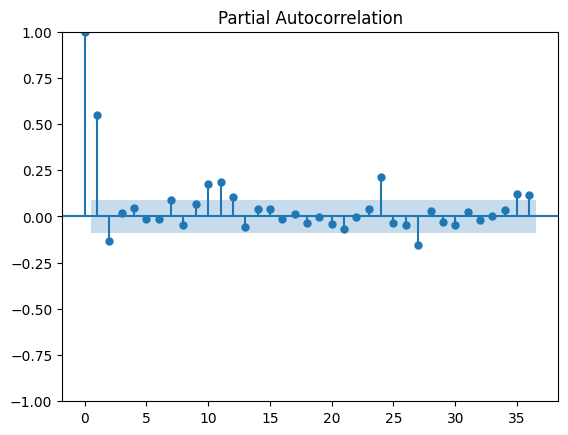

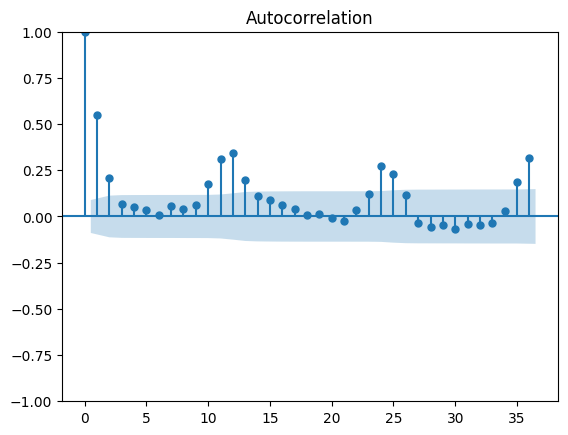

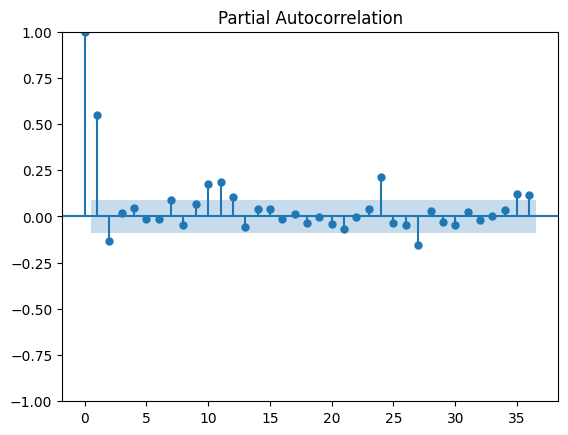

In [122]:
# ADF Test results
print("ADF test p-value", sm.tsa.stattools.adfuller(cpi.iloc[:-48], regression="n", regresults=True, store=True)[1])

tsaplots.plot_acf(cpi.iloc[:-48], lags=36)
tsaplots.plot_pacf(cpi.iloc[:-48], lags=36)

                                     SARIMAX Results                                      
Dep. Variable:                    CPALTT01USM657N   No. Observations:                  483
Model:             ARIMA(2, 0, 0)x(0, 0, [1], 12)   Log Likelihood                   0.215
Date:                            Fri, 13 Dec 2024   AIC                             37.571
Time:                                    21:48:59   BIC                            116.991
Sample:                                01-01-1980   HQIC                            68.781
                                     - 03-01-2020   Scale                            0.058
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5102      0.047     10.785      0.000       0.417       0.603
drift         -0.0022      0.001   

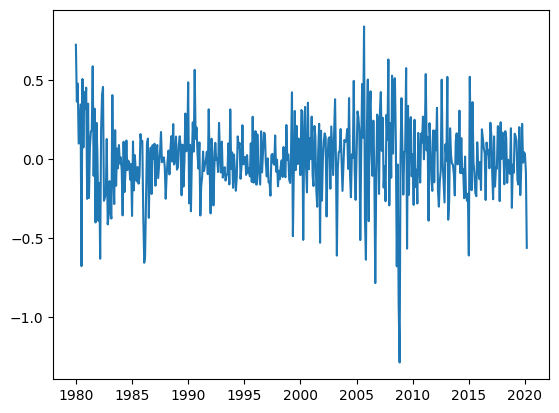

In [125]:
# SARIMA AND SARIMAX models

data = pd.DataFrame({
    'date': pd.date_range(start='1980-01-01', periods=len(cpi), freq='M')  # Example data
})
data['month'] = data['date'].dt.month
data['month'] = data['month']

# Create dummy variables for the months
month_dummies = pd.get_dummies(data['month'], prefix='month', dtype=int)
month_dummies.index = cpi.index

# SARIMAX model
model = sm.tsa.ARIMA(cpi.iloc[:-48], order=(2,0,0), dates=cpi.index, concentrate_scale=True, seasonal_order=(0,0,1,12), trend="ctt", exog=month_dummies.iloc[:-48])

# SARIMA model
# model = sm.tsa.ARIMA(cpi.iloc[:-48], order=(1,0,3), dates=cpi.index, concentrate_scale=True, seasonal_order=(4,0,0,12), trend="c")

sarima_res = model.fit()
print(sarima_res.summary())

plt.plot(sarima_res.resid)



Absoule Error 14.118567181004627
Squared Error: CPALTT01USM657N    7.548022
dtype: float64


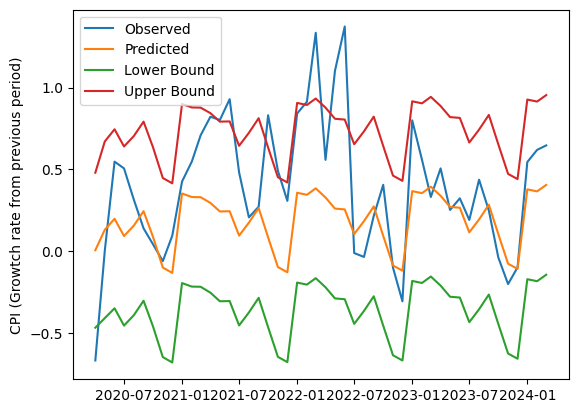

In [116]:
# Forecast for SARIMAX
forecast_sarima = sarima_res.get_forecast(steps=48, exog=month_dummies.iloc[-48:])

# Forecast for SARIMA
# forecast_sarima = sarima_res.get_forecast(steps=48)

forecast_mean = forecast_sarima.predicted_mean
forecast_ci = forecast_sarima.conf_int(alpha=0.05)


# Errors calculation
se = []
for i in range(len(forecast_mean)):
    se.append((forecast_mean.iloc[i] - cpi.iloc[(-48 + i)])**2)  #
se_total = sum(se)
ae = abs(forecast_mean - cpi.iloc[-48:,0])

print("Absoule Error", sum(ae))
print("Squared Error:", se_total)

plt.plot(cpi.iloc[-48:])
plt.plot(forecast_mean)
plt.plot(forecast_ci)
plt.ylabel('CPI (Growtch rate from previous period)')
plt.legend(["Observed","Predicted","Lower Bound","Upper Bound"])

ADF test p-value 0.0003059341148227899
                               SARIMAX Results                                
Dep. Variable:         SPDYNTFRTINUSA   No. Observations:                   39
Model:                 ARIMA(0, 1, 2)   Log Likelihood                  79.298
Date:                Fri, 13 Dec 2024   AIC                           -152.596
Time:                        21:49:38   BIC                           -147.683
Sample:                    01-01-1980   HQIC                          -150.848
                         - 01-01-2018   Scale                            0.001
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5075      0.153      3.315      0.001       0.207       0.808
ma.L2          0.2595      0.132      1.965      0.049       0.001       0.518
Ljung-Box (L1

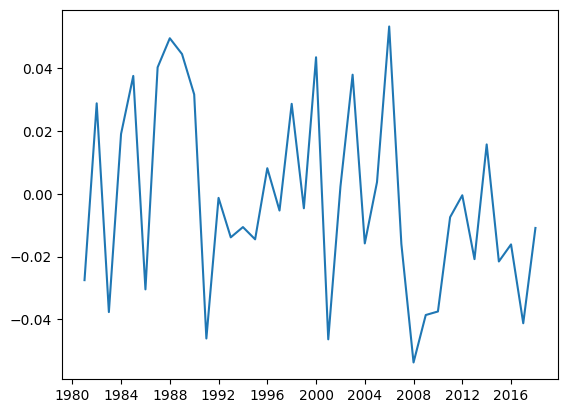

In [126]:
# ARIMA models
fertility = pdr.get_data_fred("SPDYNTFRTINUSA", start, end)

print("ADF test p-value", sm.tsa.stattools.adfuller(fertility.diff().dropna(), regression="n", regresults=True, store=True)[1])
# tsaplots.plot_acf(fertility.iloc[:-4], lags=6)
# tsaplots.plot_pacf(fertility.iloc[:-4], lags=6)

model_2 = sm.tsa.ARIMA(fertility.iloc[:-4], order=(0,1,2), dates=fertility.index, concentrate_scale=True) 
# model_2 = sm.tsa.ARIMA(fertility.iloc[:-4], order=(0,1,2), dates=fertility.index, concentrate_scale=True) 
arima = model_2.fit()

print(arima.summary())

plt.plot(arima.resid.iloc[1:])

Squared Error: SPDYNTFRTINUSA    0.00903
dtype: float64
Absolute Error: 0.16812062138903694


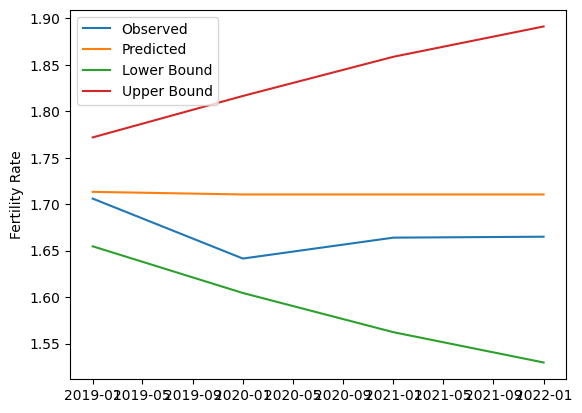

In [127]:
arima_forecast = arima.get_forecast(steps=4)
arima_mean = arima_forecast.predicted_mean
arima_ci = arima_forecast.conf_int(alpha=0.05)


se_2 = []
for i in range(len(arima_mean)):
    se_2.append((arima_mean.iloc[i] - fertility.iloc[-4 + i])**2)  # Use ** for squaring
mse_total_2 = sum(se_2)
abs_2 = abs(arima_mean - fertility.iloc[-4:,0])

print("Squared Error:", mse_total_2)
print("Absolute Error:", sum(abs_2))

plt.plot(fertility.iloc[-4:])
plt.plot(arima_mean)
plt.plot(arima_ci)
plt.ylabel('Fertility Rate')
plt.legend(["Observed","Predicted","Lower Bound","Upper Bound"])